# Demonstration Notebook

Train a model to recognize notes from input sounds

## Part 1: Data Preparation and Exploration

By Ben Walsh \
For Bnaura

&copy; 2021 Ben Walsh <ben@bnaura.com>

## Contents

1. [Import Libraries](#lib_import)
1. [Data Import](#data_import)
1. [Data Exploration](#data_explore)
1. [Data Augmentation](#data_aug)
1. [Feature Extraction](#feat_extract)
1. [Save Features](#feat_save)


TO DO
- Consider variable time length
- Add column to database for train=1, test=0
- Generalize training functions to look for any files matching corresponding note tag
  - Add _Male2 recordings
- Submodule repo into simple_gui

In [1]:
%load_ext autoreload
%autoreload 2

## <a id = "lib_import"></a>1. Import Libraries

In [2]:
import sys
import os
import datetime
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import ipywidgets as widgets

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import pickle
import sqlite3

from scipy.io import wavfile as wav
from IPython.display import Audio

# Add custom modules to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import util.music_util as mus 
from util.ml_util import feat_extract, load_training_data
from util import DATA_FOLDER, SCALE


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## <a id = "data_import"></a>2. Data Import

In [3]:
X, y, fs = load_training_data(SCALE)

C:\Users\benja\Documents\Python\note-recognition\util\ml_util.py:126: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wav.read(training_data[note])


## <a id = "data_explore"></a> 3. Data Exploration

### Overview
Sanity check the dimensions of X and y

In [4]:
print('X is a {} with shape {}'.format(type(X), X.shape))
print('X has {} rows, and expected # of rows from notes = {}'.format(X.shape[0], len(SCALE)))
print('X sample length is {}'.format(X.shape[1]))
print('y has {} samples, and expected # of samples from notes = {}'.format(len(y), len(SCALE)))

X is a <class 'numpy.ndarray'> with shape (6, 120000)
X has 6 rows, and expected # of rows from notes = 6
X sample length is 120000
y has 6 samples, and expected # of samples from notes = 6


### Plot Waveform

In [5]:
def plot_note_over_time(idx=0):
    
    # Check valid input
    valid_inputs = set(range(0, X.shape[0]))
    if idx not in valid_inputs:
        print('Error - index input {} not in valid range {}'.format(idx, valid_inputs))
        return
    
    # Create array of time samples, converting number of samples and dividing by sample of frequency 
    t_array = np.arange(X.shape[1])/fs

    # Plot waveform over short time period to see sine
    plt.subplot(121)
    plt.xlabel('Time (s)')
    plt.title('Hummed {}: {} Hz'.format(SCALE[idx], mus.note_to_freq[SCALE[idx]]))
    plt.plot(t_array, X[idx,:])

    # Plot waveform over shorter time period to see sine
    plt.subplot(122)
    plt.xlim(0.5 ,0.55)
    plt.xlabel('Time (s)')
    plt.title('Hummed {}: {} Hz'.format(SCALE[idx], mus.note_to_freq[SCALE[idx]]))
    plt.plot(t_array, X[idx,:])

    plt.show()
    

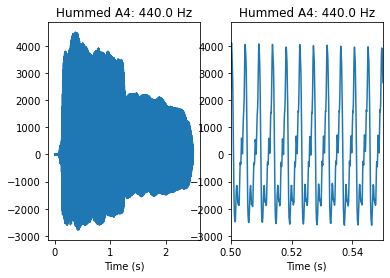

In [9]:
# Pick a note to plot
idx_test=5
plot_note_over_time(idx=idx_test)

### Plot Frequency

In [10]:
def plot_note_over_freq(idx=0):

    # Take FFT
    ftransform = np.fft.fft(X[idx,:])/X.shape[1]
    ftransform = ftransform[range(int(len(X[idx,:])/2))]
    tp_count = X.shape[1]
    vals = np.arange(tp_count/2)
    t_period = tp_count/fs

    # Scale to Hz frequency values for plotting
    freqs = vals/t_period

    plt.plot(freqs, abs(ftransform))
    plt.xlim((0, 2*mus.note_to_freq[SCALE[idx]]))
    plt.xlabel('Frequency (Hz)')
    plt.title('Hummed {}: {} Hz'.format(SCALE[idx], mus.note_to_freq[SCALE[idx]]))
    plt.show()

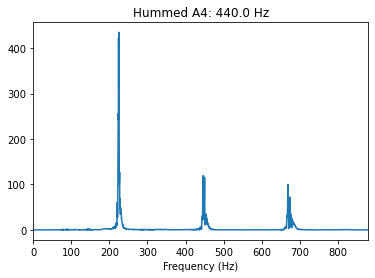

In [11]:
plot_note_over_freq(idx=idx_test)

## <a id = "data_aug"></a> 4. Data Augmentation 

Synthesize dataset `aug_factor` times larger

In [13]:
aug_factor = 10

# Initialize matrix where each row contains a noisy sample
X_aug = np.empty((aug_factor*X.shape[0], X.shape[1]))
y_aug = pd.DataFrame(np.empty((aug_factor*X.shape[0], 1)), columns=['note'])

### 4.0 Concatenate and split two-note melodies
Notes have slightly different lengths so helps to generalize with different note combinations in long melodies. Will add in the future

### 4.1 Add time shifts

Demonstrate time shift code

In [14]:
arr1 = np.array(np.arange(1,6))
print(arr1)
print(mus.add_timeshifts(arr1, samp_shift_max=4, debug=True))

[1 2 3 4 5]
Shape of input array = (5,)
Input samp_shift_max = 4
Random prepad_len = 1
[0. 1. 2. 3. 4.]


Apply time shifts to augmented training data

In [15]:
# Add random time shifts noise to each element
T_SHIFT_MAX = 0.0 # seconds
DEBUG=False

#X_aug = X_aug.apply(lambda x: mus.add_timeshifts(x, 
#                                         samp_shift_max=np.int(T_SHIFT_MAX*fs), 
#                                         debug=DEBUG), axis=1) 

for idx in range(X.shape[0]):
            
    # Initialize truth values in synthesized set
    y_aug.loc[aug_factor*idx:aug_factor*(idx+1)]=SCALE[idx]
    
    for sample in range(aug_factor):
        X_aug[sample+aug_factor*idx,:] = mus.add_timeshifts(X[idx,:], samp_shift_max=np.int(T_SHIFT_MAX*fs), debug=DEBUG)        

### 4.2 Add noise 
Add noise to original recordings

In [16]:
NOISE_AMPL = 0 #200

# Add white noise to each element
X_aug = pd.DataFrame(X_aug).apply(lambda x: mus.add_noise(x, 
                                    ampl=NOISE_AMPL),
                                    axis=1).values

Sanity check the dimensions of the augmented training set

In [17]:
print('X_aug has shape {}, with aug_factor = {}'.format(X_aug.shape, aug_factor))
print('Original X has shape {}'.format(X.shape))
print('y_aug has shape {}'.format(y_aug.shape))

X_aug has shape (60, 120000), with aug_factor = 10
Original X has shape (6, 120000)
y_aug has shape (60, 1)


### Plot example with added noise and shifts

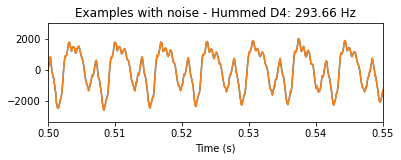

In [18]:
idx_test = 1
signal_test1 = X_aug[idx_test*aug_factor,:]
signal_test2 = X_aug[idx_test*aug_factor+1,:]
note_test = SCALE[idx_test]
t_array = np.arange(X.shape[1])/fs

# Plot waveform over shorter time period to see sine
plt.subplot(212)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Examples with noise - Hummed {}: {} Hz'.format(note_test, mus.note_to_freq[note_test]))
plt.plot(t_array, signal_test1)
plt.plot(t_array, signal_test2)

plt.show()

## <a id = "feat_extract"></a> 5. Feature Extraction 

In [19]:
X_feat = feat_extract(X_aug, fs, mus.note_to_freq, SCALE, debug=True)

Feature extraction processing time = 1.86


In [20]:
X_feat.head()

,mfcc_logfbank_0,mfcc_logfbank_1,mfcc_logfbank_2,mfcc_logfbank_3,mfcc_logfbank_4,mfcc_logfbank_5,mfcc_logfbank_6,mfcc_logfbank_7,mfcc_logfbank_8,mfcc_logfbank_9,...,mfcc_logfbank_16,mfcc_logfbank_17,mfcc_logfbank_18,mfcc_logfbank_19,mfcc_logfbank_20,mfcc_logfbank_21,mfcc_logfbank_22,mfcc_logfbank_23,mfcc_logfbank_24,mfcc_logfbank_25
0,2944.45331,2948.299865,2808.305759,2616.464812,2076.345819,1954.088585,1860.489985,2414.4367,2489.57071,2110.212162,...,2380.796365,2431.190716,2319.268894,2241.163086,2218.549561,1722.748188,1062.647365,1455.358184,1839.186824,2090.537214
1,2944.45331,2948.299865,2808.305759,2616.464812,2076.345819,1954.088585,1860.489985,2414.4367,2489.57071,2110.212162,...,2380.796365,2431.190716,2319.268894,2241.163086,2218.549561,1722.748188,1062.647365,1455.358184,1839.186824,2090.537214
2,2944.45331,2948.299865,2808.305759,2616.464812,2076.345819,1954.088585,1860.489985,2414.4367,2489.57071,2110.212162,...,2380.796365,2431.190716,2319.268894,2241.163086,2218.549561,1722.748188,1062.647365,1455.358184,1839.186824,2090.537214
3,2944.45331,2948.299865,2808.305759,2616.464812,2076.345819,1954.088585,1860.489985,2414.4367,2489.57071,2110.212162,...,2380.796365,2431.190716,2319.268894,2241.163086,2218.549561,1722.748188,1062.647365,1455.358184,1839.186824,2090.537214
4,2944.45331,2948.299865,2808.305759,2616.464812,2076.345819,1954.088585,1860.489985,2414.4367,2489.57071,2110.212162,...,2380.796365,2431.190716,2319.268894,2241.163086,2218.549561,1722.748188,1062.647365,1455.358184,1839.186824,2090.537214


### Explore extracted features

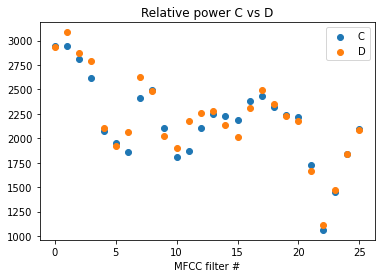

In [21]:
NOTE_TEST1 = 'C'
NOTE_TEST2 = 'D'
plt.scatter(np.arange(X_feat.shape[1]), X_feat[y_aug['note'].str.contains(NOTE_TEST1)].mean())
plt.scatter(np.arange(X_feat.shape[1]), X_feat[y_aug['note'].str.contains(NOTE_TEST2)].mean())
plt.legend([NOTE_TEST1, NOTE_TEST2])

#plt.bar(SCALE, X_feat[y_aug['note'].str.contains(NOTE_TEST)].mean())
plt.title('Relative power {} vs {}'.format(NOTE_TEST1, NOTE_TEST2))
plt.xlabel('MFCC filter #')
plt.show()

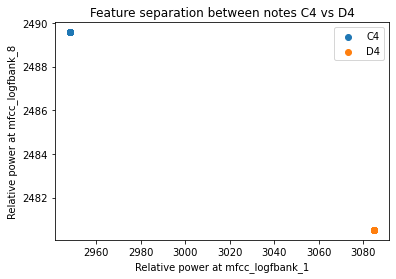

In [22]:
NOTE1 = 'C4'
NOTE2 = 'D4'

feat1 = 'mfcc_logfbank_1'
feat2 = 'mfcc_logfbank_8'

plt.scatter(X_feat[y_aug['note'].str.contains(NOTE1)][feat1], 
            X_feat[y_aug['note'].str.contains(NOTE1)][feat2])
plt.scatter(X_feat[y_aug['note'].str.contains(NOTE2)][feat1], 
            X_feat[y_aug['note'].str.contains(NOTE2)][feat2])

plt.ylabel('Relative power at {}'.format(feat2))
plt.xlabel('Relative power at {}'.format(feat1))
plt.legend([NOTE1, NOTE2])
plt.title('Feature separation between notes {} vs {}'.format(NOTE1, NOTE2))
plt.show()

## <a id = "feat_save"></a> 6. Save Features

### Using SQL

In [39]:
# Define name of database and table
FEAT_DB_NAME = os.path.join(DATA_FOLDER, 'features.db')
TABLE_NAME = 'X_all'

# Connect to database
conn = sqlite3.connect(FEAT_DB_NAME)
c = conn.cursor()

# Create feature-agnostic SQL phrases to define table structure and insert values
col_phrase = ' real, '.join(X_feat.columns)+' real'
val_phrase = '?,'*(len(X_feat.columns)-1)+'?'

# Create table
c.execute('''CREATE TABLE IF NOT EXISTS {} ({})'''.format(TABLE_NAME, col_phrase))

# Commit the changes to db
conn.commit()

# Insert multiple records in a single query
c.executemany('INSERT INTO {} VALUES({});'.format(TABLE_NAME, val_phrase), X_feat.values);
conn.commit()

# Close the connection
conn.close()


### Using CSV

Split data for training and testing and save off features

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y_aug, random_state=1)

if not(os.path.exists(DATA_FOLDER)):
    os.mkdir(DATA_FOLDER)

X_train.to_csv(os.path.join(DATA_FOLDER, 'X_train.csv'), index=False)
X_test.to_csv(os.path.join(DATA_FOLDER, 'X_test.csv'), index=False)

y_train.to_csv(os.path.join(DATA_FOLDER, 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(DATA_FOLDER, 'y_test.csv'), index=False)